In [1]:
import os
DATA_DIR = os.path.abspath(os.path.join('../Data' ))
SHAPE_DIR = os.path.abspath(os.path.join('../shape_files' ))
FIG_DIR = os.path.abspath(os.path.join('../Figures' ))

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import geopandas as gpd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set_palette("colorblind")
sns.set_style("darkgrid")

In [19]:
def plot_states(states: list, together=False, norm = 'none'):
    """
    norm == normalization factor
    
    if pop: per 100 K residents
    if density : divided by density
    if none: raw numbers
    
    """

    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv' 
    df_states = pd.read_csv(url)
    df_states['date'] = pd.to_datetime(df_states['date'])
    
    info = pd.read_csv(f"{DATA_DIR}/states_info.csv", 
                       usecols = ['ST', 'NAME', 'LD', 'Population','density','Governor', 'Party affiliation'],
                       index_col=['NAME']) 

    if not together:
        for state in states :

            pop = info.loc[state,'Population']


            df_copy = df_states[df_states['state'] == state].copy()
            df_copy['new_cases'] = np.diff(df_copy['cases'].values, prepend =0)
            df_copy['new_deaths'] = np.diff(df_copy['deaths'].values, prepend =0)

            fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(10,5), constrained_layout=True)
            fig.suptitle(f"{state}", size=20)
            formatter = mdates.DateFormatter("%m-%d")
            locator = mdates.MonthLocator()

            ax1.plot(df_copy['date'],df_copy['cases']*1e5/pop,'-') 
            ax1.set_ylabel('cumulative cases \n per 100k residents')


            ax2.plot(df_copy['date'],df_copy['deaths']*1e5/pop,'-', color = 'C1')        
            ax2.set_ylabel('cumulative deaths \n per 100k residents')


            ax3.plot(df_copy['date'],df_copy['new_cases']*1e5/pop,'o',alpha=0.2)
            ax3.fill_between(df_copy['date'], 
                     df_copy['new_cases'].rolling(7, win_type='gaussian').mean(std=3)*1e5/pop,
                     alpha=0.4)
            ax3.set_ylabel('daily cases \n per 100k residents')

            ax4.plot(df_copy['date'],df_copy['new_deaths']*1e5/pop,'^', alpha=0.2, color = 'C1')   
            ax4.fill_between(df_copy['date'], 
                     df_copy['new_deaths'].rolling(7, win_type='gaussian').mean(std=3)*1e5/pop, 
                     alpha=0.4, color = 'C1')
            ax4.set_ylabel('daily deaths \n per 100k residents')

            for ax in [ax1,ax2,ax3,ax4]:
                ax.set_xlabel('Date')
                ax.xaxis.set_major_formatter(formatter)
                ax.xaxis.set_major_locator(locator)
                ax.axvline(info.loc[state, 'LD'], color='k', ls = '-.', alpha=0.4)
            plt.show()
    else:
            
        fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(15,15), constrained_layout=True)
        formatter = mdates.DateFormatter("%m-%d")
        locator = mdates.MonthLocator()
        
        for state in states:
            pop = info.loc[state,'Population']
            density = info.loc[state,'density']
            
            if norm=='none':
                k = 1
                s=''
                
            elif norm=='pop':
                k = 1e5/pop
                s = 'per 100k residents'
            elif norm=='density':
                k = 1/density
                s =  '/ density'
                
            df_copy = df_states[df_states['state'] == state].copy()
            df_copy['new_cases'] = np.diff(df_copy['cases'].values, prepend =0)
            df_copy['new_deaths'] = np.diff(df_copy['deaths'].values, prepend =0)
            
            ax1.plot(df_copy['date'],df_copy['cases']*k,'-', label=state, lw=5) 
            ax2.plot(df_copy['date'],df_copy['deaths']*k,'-', label=state, lw=5)    
            ax3.plot(df_copy['date'], 
                     df_copy['new_cases'].rolling(7, win_type='gaussian').mean(std=5)*k, '-'
                     ,label=state, lw=5)
            ax4.plot(df_copy['date'], 
                     df_copy['new_deaths'].rolling(7, win_type='gaussian').mean(std=5)*k, '-'
                     ,label=state, lw=5)
#             for ax in [ax1,ax2,ax3,ax4]:
#                 ax.axvline(info.loc[state, 'LD'], color='k', alpha=0.2)
           
        
        ax1.set_ylabel(f'cumulative cases \n {s}', size=15)
        ax2.set_ylabel(f'cumulative deaths \n {s}', size=15)
        ax3.set_ylabel(f'daily cases \n {s}', size=15)
        ax4.set_ylabel(f'daily deaths \n {s}', size=15)
        
        ax1.set_title(f'cumulative cases \n {s}', size=15)
        ax2.set_title(f'cumulative deaths \n {s}', size=15)
        ax3.set_title(f'daily cases \n {s}', size=15)
        ax4.set_title(f'daily deaths \n {s}', size=15)
        
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_xlabel('Date', size=15)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_major_locator(locator)
            ax.legend(ncol=2, fontsize='medium')
        

        
       

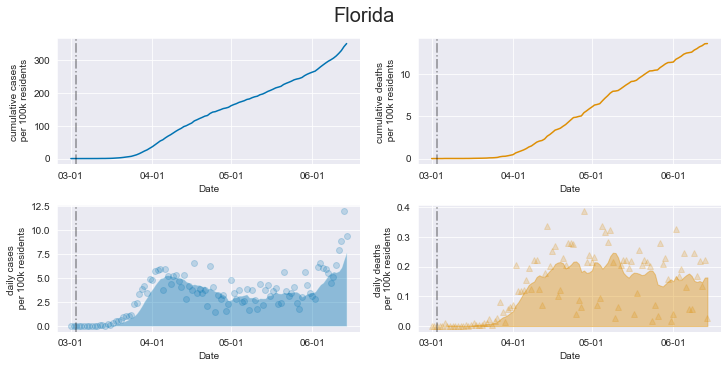

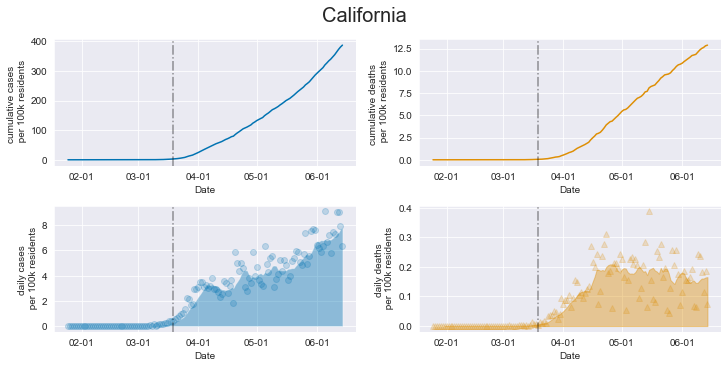

In [20]:
info = pd.read_csv(f"{DATA_DIR}/states_info.csv", 
                       usecols = ['ST', 'NAME', 'LD', 'Population','density','Governor', 'Party affiliation'],
                       index_col=['NAME']) 
plot_states(['Florida', 'California'], together=False)
# plot_states(info['density'].sort_values(ascending=False)[:2].index.values, together=False, norm='pop')

In [4]:
def plot_US(exclude=[], start_date = ''):

    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv' 
    df_states = pd.read_csv(url)
    df_states['date'] = pd.to_datetime(df_states['date'])
    
    y_cc  = df_states[~df_states['state'].isin(exclude)].groupby('date')['cases'].sum()
    y_cd = df_states[~df_states['state'].isin(exclude)].groupby('date')['deaths'].sum()
    
    y_nc = pd.Series(np.diff(y_cc.rolling(7, win_type='gaussian').mean(std=5).values, prepend =0), index = y_cc.index)
    y_nd = pd.Series(np.diff(y_cd.rolling(7, win_type='gaussian').mean(std=5).values, prepend =0), index = y_cd.index)

    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    formatter = mdates.DateFormatter("%m-%d")
    locator = mdates.MonthLocator()


    ax1.plot(y_cc.index, y_nc,'-',lw=2, color = 'C0')
    ax2.plot(y_cd.index, y_nd,'-', lw=2, color ='C1')
    ax1.fill_between(y_cc.index, y_nc, alpha=0.3, facecolor ='C0')
    ax2.fill_between(y_cd.index, y_nd, alpha=0.3, facecolor ='C1')
    
    if len(exclude)==0:
        s=''
    else:
        l=''
        for state in exclude:
            l+=state+ ' '
        s='\n excluding: '+ l

    ax1.set_title(f'Daily cases in the US {s}',size=12)
    ax1.set_ylabel('Daily cases', size=12)

    ax2.set_title(f'Daily deaths in the US {s}',size=12)
    ax2.set_ylabel('Daily deaths', size=12)
    for ax in [ax1,ax2]:
        ax.set_xlabel('Date',size=12)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)
    
    low = y_cc.index[0]
    hi = y_cc.index[-1]
    
    if start_date:
        low = pd.to_datetime(start_date)
    
    ax1.set_xlim(low, hi)
    ax2.set_xlim(low, hi)

    
    

    plt.tight_layout()
    plt.show()

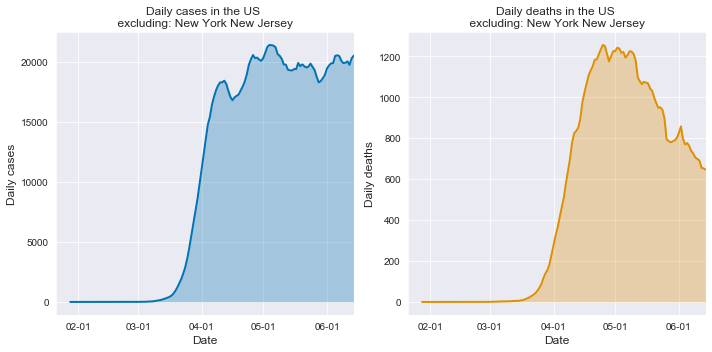

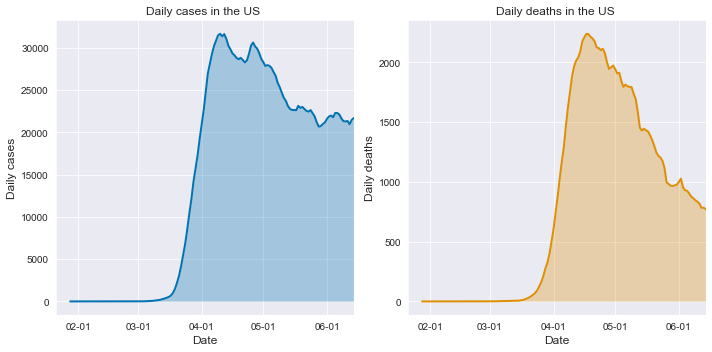

In [5]:
plot_US(exclude=['New York', 'New Jersey'], start_date='')
plot_US(exclude=[], start_date='')

In [6]:
def state_heatmap(state: str, start_date=''):
    """
    Plots Heatmaps for counties in state showing daily new cases from the first case to present.
    
    """
    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv' 

    df_counties = pd.read_csv(url)
    df_counties.date = pd.to_datetime(df_counties.date)
    df = df_counties[df_counties.state==state].groupby(['date', 'county'])['cases'].sum()
    
    info = pd.read_csv(f"{DATA_DIR}/states_info.csv", 
                       usecols = ['NAME','FIPS'],
                       index_col=['NAME'])
   
    shapefile = gpd.read_file(f'{SHAPE_DIR}/cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
    shapefile = shapefile[shapefile.STATEFP==str(info.loc[state, 'FIPS'])]
    shapefile = shapefile.sort_values('NAME', ignore_index=True)

    shapefile['diff_cases'] = pd.Series(np.zeros(len(shapefile)))
    

    X_list =  shapefile.centroid.geometry.x
    Y_list =  shapefile.centroid.geometry.y
    county_list = sorted(shapefile.NAME.str.title().values)
    
    
    dates = pd.unique(df_counties[df_counties.state==state]['date'])
    
    
    if start_date:
        start_date = pd.to_datetime(start_date)
        if start_date < dates[0]:
            print("start date you entered is before the first case")
            print("using first available date instead.") 
            dates = dates[1:3]
        elif start_date >= dates[-1]:
            print("We dont have data beyond your start date.")
            print("Please use an earlier date")
            print("using last available date instead")
            dates =dates[-2:]
        else:
            dates = [d for d in dates if d>=start_date]
            
    
        
    for i in range(1,len(dates)): 
        
        df_date = pd.merge(pd.DataFrame(index=county_list),
                           df.loc[dates[i]].to_frame(), 
                           how='left', left_index=True, right_index=True)
       
        
        df_date.fillna(0, inplace=True)
        
        
        
        df_yesterday = pd.merge(pd.DataFrame(index=county_list),
                           df.loc[dates[i-1]].to_frame(), 
                           how='left', left_index=True, right_index=True)
        
        df_yesterday.fillna(0, inplace=True)
       

        shapefile['diff_cases'] = pd.Series(df_date['cases'].values - df_yesterday['cases'].values)
        shapefile['cases'] = pd.Series(df_date['cases'].values)

        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8), constrained_layout=True)
        divider = make_axes_locatable(ax1)
        cax1 = divider.append_axes("right", size="5%", pad=0.2) 
        divider = make_axes_locatable(ax2)
        cax2 = divider.append_axes("right", size="5%", pad=0.2) 

        shapefile.plot(column ='diff_cases', cmap = 'seismic',legend = True, 
                       ax = ax1, cax=cax1, vmin=-100, vmax=100)
        shapefile.plot(column ='cases', cmap = 'viridis',legend = True, 
                       ax = ax2, cax=cax2)
#         for x,y,county in zip(X_list,Y_list,county_list):
#             ax.text(x,y,county[:3], fontsize = 10, color = 'k', alpha =0.6)
            
        for ax in [ax1, ax2]:
            ax.grid([])
            ax.set_xticks([])
            ax.set_yticks([])
        ax1.set_title('Change from ' + str(dates[i-1])[5:10]+ ' to ' +str(dates[i])[5:10])
        ax2.set_title('Cases till '+ str(dates[i])[5:10])
        
#         plt.savefig(f"{FIG_DIR}/heatmaps/{str(dates[i])[:10]}.png", dpi=300)
#         plt.close()
        plt.show()
        
    
       
    
    

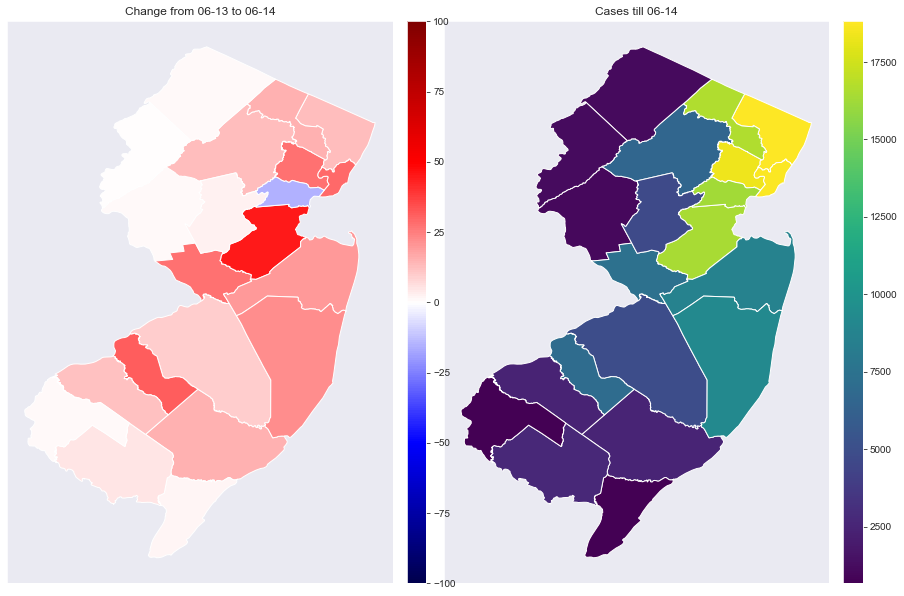

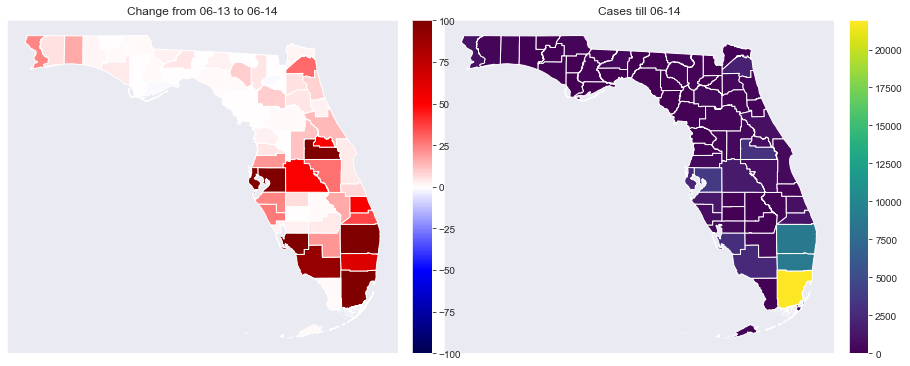

In [7]:
state_heatmap('New Jersey', start_date='2020-06-13')
state_heatmap('Florida', start_date='2020-06-13')